In [9]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from data_loader import load_probe_data, load_reference_data
import training_VPINN_1DSWE as training
import network as network

Settings: PDE-Problem

In [10]:
# Domain
# PDE is scaled such that network inputs are x \in [-1,1], t \in [0,1]
Xscale = 1000               # spatial domain: Xscale * [-1,1]
Tscale = 600                # temporal domain: Tscale * [0,1]
g = torch.tensor([9.81])    # gravitational acceleration
cd = torch.tensor([0.01])   # friction coefficient

# function for bed elevation
def fct_bed(x):
    a = 2
    sigma = 200
    return a*torch.exp(-x**2/(2*sigma**2))

# spatial derivative of bed elevation
def fct_dbeddx(x):
    a = 2
    sigma = 200
    return -x/sigma**2*a*torch.exp(-x**2/(2*sigma**2))

# load water depth observations and reference data
n_probe = 5                 # number of probes [2,3,5,9]
T_sample = 10               # sampling period (min value is 1s)
noise = 0                   # add noise from Gaussian distribution where sigma=noise
pts_probe, h_probe = load_probe_data(n_probe,T_sample,noise)
t_ref, x_ref, h_ref, u_ref = load_reference_data()

Settings: VPINN and Training

In [11]:
# network architecture
n_in = 2                # number of inputs
n_out = 2               # number of outputs
n_l = 5                 # number of hidden layers
n_n = 200               # number of neurons per layer
activation = nn.Tanh    # activation function

# variational PDE loss
n_sub = 9             # number of subdomains in each dimension
n_gauss = 26           # number of quadrature nodes for each subdomain in each dimension
n_test = 7             # number of different Legendre polynomials in each dimension

# training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weights = torch.tensor([1,1,1])                                         # loss term weights [continuity eq, momentum eq, observations]
n_iter = int(5e4+1)                                                     # number of training iterations
lr = 0.0005                                                             # ADAM learning rate
freq_eval = 100                                                         # sampling period [iterations] of losses

VPINN: Initialization

In [12]:
# initialize model
SWE_pinn = network.net(n_in, n_l, n_n, n_out, activation)
SWE_train = training.TrainModel(device, SWE_pinn, lr, weights,
                                fct_dbeddx, Tscale, Xscale, g, cd,
                                n_sub, n_gauss, n_test,
                                pts_probe, h_probe)
# initialize storage container
losses = []
epochs = []

VPINN: Training

In [13]:
# train model
start_time = time.time()
for iter in tqdm(range(n_iter), desc="Training Progress", unit="iter"):
    SWE_train.train()
    if iter % freq_eval == 0:
        epochs.append(iter)
        losses.append(SWE_train.losses().detach().cpu().numpy())

Training Progress:   0%|          | 0/50001 [00:00<?, ?iter/s]

VPINN: Final Performance

In [14]:
# normalized root mean squared error (nRMSE)
def fct_nrmse(pred,true):
    nrmse = torch.sqrt(torch.mean((pred - true)** 2))/(torch.max(true)-torch.min(true))
    return nrmse

# evaluate model
pts_ref = torch.cat(((t_ref/Tscale).reshape(-1,1),(x_ref/Xscale).reshape(-1,1)), dim=1).to(device)
pred = SWE_pinn.forward(pts_ref),
h_pred = pred[0][:,0].detach().cpu()
u_pred = pred[0][:,1].detach().cpu()
nrmse_h = fct_nrmse(h_pred,h_ref.reshape(-1))
nrmse_u = fct_nrmse(u_pred,u_ref.reshape(-1))
print(f'nNRMSE(h) = {nrmse_h.item():.4f}')
print(f'nNRMSE(u) = {nrmse_u.item():.4f}')

nNRMSE(h) = 0.0107
nNRMSE(u) = 0.0200


Plots

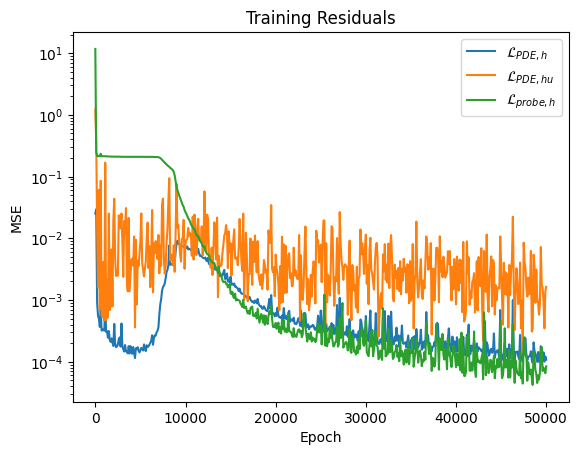

In [15]:
# network training performance
epochs = np.array(epochs)
losses = np.stack(losses)
labels=[r'$\mathcal{L}_{PDE,h}$',r'$\mathcal{L}_{PDE,hu}$',
        r'$\mathcal{L}_{probe,h}$']
for i in range(len(weights)):
    plt.plot(epochs,losses[:,i], label=labels[i])

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training Residuals')
plt.legend()
plt.yscale("log")

Text(0.5, 0.98, 'Prediction at t=450s')

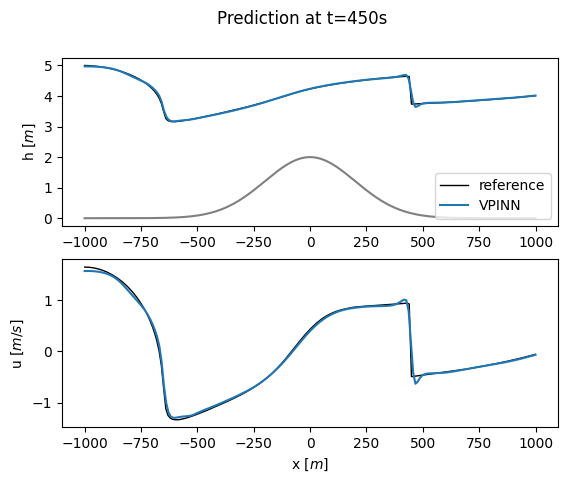

In [18]:
# prediction at specific point in time
t_pred = 450
x_pred = torch.linspace(-Xscale,Xscale,200);
in_pred = torch.hstack((t_pred/Tscale*torch.ones_like(x_pred).reshape(-1,1), (x_pred/Xscale).reshape(-1,1))).to(device)
pred = SWE_pinn.forward(in_pred).detach().cpu()

idx = torch.abs(t_ref[:,1]-t_pred).argmin() # find closest reference data w.r.t time

fig, ax = plt.subplots(2,1)
ax[0].plot(x_ref[idx,:],h_ref[idx,:] + fct_bed(x_ref[idx,:]), 'k', lw=1, label='reference')
ax[0].plot(x_pred, pred[:,0] + fct_bed(x_pred), label= 'VPINN')
ax[0].plot(x_pred,fct_bed(x_pred), color='gray')
ax[1].plot(x_ref[idx,:],u_ref[idx,:], 'k', lw=1)
ax[1].plot(x_pred,pred[:,1])
ax[0].legend(loc='lower right')
ax[0].set_ylabel(r'h [$m$]')
ax[1].set_xlabel(r'x [$m$]')
ax[1].set_ylabel(r'u [$m/s$]')
fig.suptitle(f'Prediction at t={str(t_pred)}s')